In [49]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


# Data Prep

Training and Testing data is prepared from the solution file

In [50]:
n = 128
x_1 = np.linspace(-1, 1, 2*n+1)
y_1 = np.linspace(1, 0, n+1)
Y_1, X_1 = np.meshgrid(y_1, x_1)
x_2 = np.linspace(-1, 0, n+1)
y_2 = np.linspace(-1/n, -1, n)
Y_2, X_2 = np.meshgrid(y_2, x_2)

x = np.vstack((X_1.flatten(order='F')[:, None], X_2.flatten(order='F')[:, None]))
y = np.vstack((Y_1.flatten(order='F')[:, None], Y_2.flatten(order='F')[:, None]))

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [51]:
X_v_test = np.hstack((x, y))
v_true = np.where(y <= 0, np.sin(2 * np.pi * x) * (1/2 * y**2 + y) * (y**2 - 1), np.sin(2 * np.pi * x) * (-1/2 * y**2 + y) * (y**2 - 1))
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
theta = np.where(theta < 0, theta + 2*np.pi, theta)
sd = r**(2/3) * np.sin(2*theta/3)
R = 1/2
etad = np.where(r < R, 15 / 16 * (
                    8 / 15 - (4 * r / R - 3) + 2 / 3 * (4 * r / R - 3) ** 3 - 1 / 5 * (4 * r / R - 3) ** 5), 0)
etad = np.where(r < R/2, 1, etad)
u_true = v_true + sd * etad

lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

# Training Data

In [52]:
def trainingdata(N_v,N_f):
    
    edge1_x = np.hstack((np.linspace(-1, 1, 2*n+1)[:, None], np.linspace(1, 1, 2*n+1)[:, None]))
    edge2_x = np.hstack((np.linspace(1, 1, n+1)[:, None], np.linspace(1, 0, n+1)[:, None]))
    edge3_x = np.hstack((np.linspace(1, 0, n+1)[:, None], np.linspace(0, 0, n+1)[:, None]))
    edge4_x = np.hstack((np.linspace(0, 0, n+1)[:, None], np.linspace(0, -1, n+1)[:, None]))
    edge5_x = np.hstack((np.linspace(0, -1, n+1)[:, None], np.linspace(-1, -1, n+1)[:, None]))
    edge6_x = np.hstack((np.linspace(-1, -1, 2*n+1)[:, None], np.linspace(-1, 1, 2*n+1)[:, None]))

    all_X_v_train = np.vstack([edge1_x, edge2_x, edge3_x, edge4_x, edge5_x, edge6_x])

    # choose random N_v points for training
    all_X_v_train_r = np.sqrt(all_X_v_train[:, 0]**2 + all_X_v_train[:, 1]**2)
    probability = np.where(all_X_v_train_r == 0, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(all_X_v_train.shape[0], N_v, replace=False, p=probability)
    X_v_train = all_X_v_train[idx[0:N_v], :]  # choose indices from  set 'idx' (x,t)
    
    '''Collocation Points'''

    # N_f sets of tuples(x,t)
    probability = np.where(r == 0, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(X_v_test.shape[0], N_f, replace=False, p=probability.T[0])
    X_f = X_v_test[idx[0:N_f], :]
    '''
    x_11 = np.linspace(-0.1, 0.1, 2*n+1)
    y_11 = np.linspace(0.1, 0, n+1)
    Y_11, X_11 = np.meshgrid(y_11, x_11)
    x_21 = np.linspace(-0.1, 0, n+1)
    y_21 = np.linspace(-0.1/n, -0.1, n)
    Y_21, X_21 = np.meshgrid(y_21, x_21)

    x0 = np.vstack((X_11.flatten(order='F')[:, None], X_21.flatten(order='F')[:, None]))
    y0 = np.vstack((Y_11.flatten(order='F')[:, None], Y_21.flatten(order='F')[:, None]))
    X_v_test_0 = np.hstack((x0, y0))
    
    r0 = np.sqrt(x0**2 + y0**2)
    #probability = np.where(r0 > 0.1, 0, 1)
    probability = np.where(r0 == 0, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(X_v_test_0.shape[0], N_f, replace=False, p=probability.T[0])
    X_f_t = X_v_test_0[idx[0:N_f], :]
    '''
    X_f_train = np.vstack((X_f,X_v_train))  # append training points to collocation points

    return X_f_train, X_v_train

# PINN

Creating sequential layers using the class
tf.Module

In [53]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a nn.MSELosslist using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_v = self.loss_function(self.forward(x), y)
                
        return loss_v
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        vv = self.forward(g)
                
        v_x = autograd.grad(vv,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_xx = autograd.grad(v_x[:,[0]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_yy = autograd.grad(v_x[:,[1]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_xx_1 = v_xx[:,[0]]
        v_xx_2 = v_yy[:,[1]]
                        
        r = torch.sqrt(x_1_f ** 2 + x_2_f ** 2)
        theta = np.arctan2(x_2_f, x_1_f)
        theta = torch.where(theta < 0, theta + 2 * np.pi, theta)
        
        deltap = torch.where(r < R,
                          -4 * (-7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (8 * r - 3) ** 3 + 3.3125) * np.sin(
                              2 * theta / 3) / (9 * r ** (4 / 3)) + (2 / 3 * (
                                  -7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (
                                  8 * r - 3) ** 3 + 3.3125) * np.sin(2 * theta / 3) / r ** (1 / 3) + r ** (
                                                                             2 / 3) * (
                                                                             -7.5 * (8 * r - 3) ** 4 + 15.0 * (
                                                                             8 * r - 3) ** 2 - 7.5) * np.sin(
                              2 * theta / 3) + r * (-2 / 9 * (-7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (
                                  8 * r - 3) ** 3 + 3.3125) * np.sin(2 * theta / 3) / r ** (4 / 3) + 4 / 3 * (
                                                            -7.5 * (8 * r - 3) ** 4 + 15.0 * (
                                                            8 * r - 3) ** 2 - 7.5) * np.sin(
                              2 * theta / 3) / r ** (1 / 3) + r ** (2 / 3) * (
                                                            1920.0 * r - 240.0 * (8 * r - 3) ** 3 - 720.0) * np.sin(
                              2 * theta / 3))) / r, 0)
        deltap = torch.where(r < R / 2, 0, deltap)

        f = torch.where(x_2_f <= 0,
                     np.sin(2 * np.pi * x_1_f) * (2 * np.pi ** 2 * (x_2_f ** 2 + 2 * x_2_f) * (x_2_f ** 2 - 1) - (
                             6 * x_2_f ** 2 + 6 * x_2_f - 1)) - deltap,
                     np.sin(2 * np.pi * x_1_f) * (2 * np.pi ** 2 * (-x_2_f ** 2 + 2 * x_2_f) * (x_2_f ** 2 - 1) - (
                             -6 * x_2_f ** 2 + 6 * x_2_f + 1)) - deltap)

        F = v_xx_1 + v_xx_2 + f
        q = F**2
        f_hat = q - q

        loss_f = self.loss_function(F, f_hat)
                
        return loss_f, q
    
    def loss(self,x,y,x_to_train_f,sigma):

        loss_v = self.loss_BC(x,y)
        loss_f, _ = self.loss_PDE(x_to_train_f)

        loss = sigma * loss_v + loss_f

        return loss
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_v_train, v_train, X_f_train, sigma)
        
        global ite, iteration_vec, error_vec, fun_vec
        ite = ite + 1
        
        if (ite % 100 == 0):
            iteration_vec.append(ite)
            fun_vec.append(loss_val.item())
            error, _ = self.test()
            error_vec.append(error.item())
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        v_pred = self.forward(X_v_test_tensor)
        
        error_vec = torch.linalg.norm((u-v_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = v_pred.cpu().detach().numpy()
        
        for i in range(n+1, 2*n+1):      # to supplement 0 to the 4th quadrant
            for j in range(n+1, 2*n+1):
                u_pred = np.insert(u_pred, i*(2*n+1)+j, 0)
        u_pred = np.reshape(u_pred, (2*n+1, 2*n+1), order='F')
        
        return error_vec, u_pred

# Loss Function

The loss function consists of two parts:

    loss_BC: MSE error of boundary losses
    loss_PDE: MSE error of collocation points satisfying the PDE

loss = loss_BC + loss_PDE


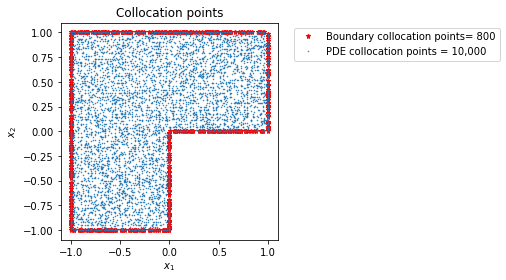

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
)
3205
tensor([-0.1471,  0.1047])


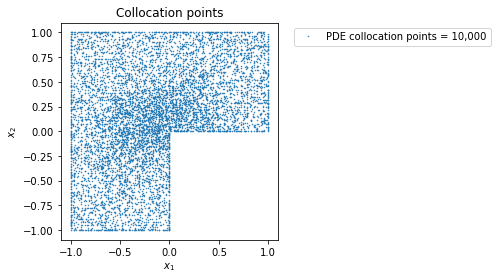

error: tensor(0.0880, grad_fn=<DivBackward0>)
4532
error: tensor(0.0667, grad_fn=<DivBackward0>)
4052
error: tensor(0.0526, grad_fn=<DivBackward0>)
3872
error: tensor(0.0414, grad_fn=<DivBackward0>)
3120
tensor([-0.1060,  0.1360])


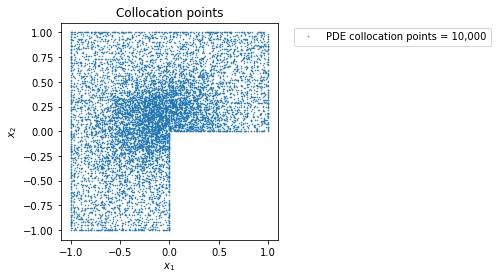

error: tensor(0.0312, grad_fn=<DivBackward0>)
4337
error: tensor(0.0278, grad_fn=<DivBackward0>)
Training time: 550.96
sigma:759.375000
Test Error: 0.02783


C:\Users\HP\AppData\Local\Temp/ipykernel_11568/3684645196.py:118: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u_pred, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_11568/3684645196.py:127: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, np.abs(u_sol - u_pred), cmap='jet')


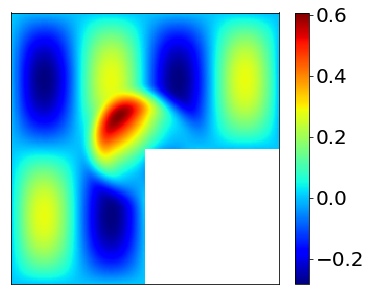

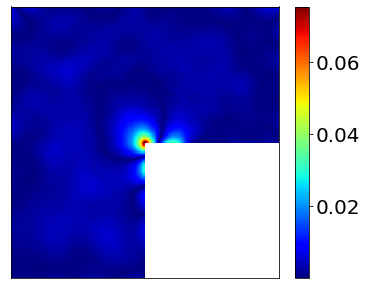

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800] [129.3489990234375, 107.0153579711914, 69.84789276123047, 25.367855072021484, 10.868474960327148, 7.354424476623535, 6.095617771148682, 5.507095813751221, 5.1708221435546875, 4.818582534790039, 4.467288970947266, 4.1273512840271, 3.854510545730591, 3.607654571533203, 3.33184051513

In [54]:
N_v = 500 
N_f = 5000

X_f_train_np_array, X_v_train_np_array = trainingdata(N_v,N_f)

fig,ax = plt.subplots()

plt.plot(X_v_train_np_array[:,0],X_v_train_np_array[:,1], '*', color = 'red', markersize = 5, label = 'Boundary collocation points= 800')
plt.plot(X_f_train_np_array[:,0],X_f_train_np_array[:,1], 'o', markersize = 0.5, label = 'PDE collocation points = 10,000')

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Collocation points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('scaled')
plt.show()

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_v_train = torch.from_numpy(X_v_train_np_array).float().to(device)
v_train = torch.zeros(X_v_train.shape[0],1).to(device)
X_v_test_tensor = torch.from_numpy(X_v_test).float().to(device)
v = torch.from_numpy(v_true).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

iteration_vec = []
fun_vec = []
error_vec = []

layers = np.array([2,20,20,20,1])

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)
params = list(PINN.parameters())
sigma = 100
error_0 = 1
s=1

start_time = time.time()

ite = 0
while s<7 and error_0>0.001:
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,
                              max_iter = 1000, 
                              max_eval = 2500, 
                              tolerance_grad = 1e-06, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizer.step(PINN.closure)
    
    _, q = PINN.loss_PDE(X_f_train)
    epsilon = 0.1
    Neta = torch.sum(torch.where(q > epsilon, 1, 0))
    fout, indices = torch.topk(q.T[0], 1000)
    X_f_train_new = X_f_train[indices,:]
    print(Neta.item())
    if Neta.item() < 0.7*N_f:
        mu = torch.hstack((torch.mean(X_f_train_new[:,[0]]),torch.mean(X_f_train_new[:,[1]])))
        print(mu)
        SIGMA = torch.matmul((X_f_train_new - mu).T, X_f_train_new - mu)/(X_f_train_new.shape[0]-1)
        X_f_train_new = np.random.multivariate_normal(mu, SIGMA, 2000)

        index = np.where(((X_f_train_new[:,[0]]>0)&(X_f_train_new[:,[0]]<1)&(X_f_train_new[:,[1]]>0)&(X_f_train_new[:,[1]]<1))|((X_f_train_new[:,[0]]>-1)&(X_f_train_new[:,[0]]<0)&(X_f_train_new[:,[1]]>-1)&(X_f_train_new[:,[1]]<1)))
        X_f_train_new = X_f_train_new[index,:]
        
        X_f_train_new = torch.from_numpy(X_f_train_new).float().to(device)
        X_f_train = torch.vstack((X_f_train, X_f_train_new[0]))
        
        fig,ax = plt.subplots()
        plt.plot(X_f_train[:,0],X_f_train[:,1], 'o', markersize = 0.5, label = 'PDE collocation points = 10,000')
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.title('Collocation points')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.axis('scaled')
        plt.show()
    
    s=s+1
    error_0, _ = PINN.test()
    sigma = 1.5 * sigma
    print('error:', error_0)
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_0, u_pred = PINN.test()

print('sigma:%f' %(sigma/1.5))
print('Test Error: %.5f'  % (error_0))

# Plotting
xx = np.linspace(-1, 1, 2*n+1)
yy = np.linspace(1, -1, 2*n+1)
Y, X = np.meshgrid(yy, xx)
for i in range(2*n+1):
    for j in range(2*n+1):
        if X[i, j] > 0 and Y[i, j] < 0:
            X[i, j] = float('nan')
            Y[i, j] = float('nan')
for i in range(n+1, 2*n+1):      # to supplement 0 to the 4th quadrant
    for j in range(n+1, 2*n+1):
        u_true = np.insert(u_true, i*(2*n+1)+j, 0)
u_sol = np.reshape(u_true, (2*n+1, 2*n+1), order='F')

# Prediction
fig_2 = plt.figure(2, figsize=(6, 5))
plt.pcolor(X, Y, u_pred, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('pred-1-FIPINN',bbox_inches='tight')

# Error
fig_3 = plt.figure(3, figsize=(6, 5))
plt.pcolor(X, Y, np.abs(u_sol - u_pred), cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('error-1-FIPINN',bbox_inches='tight')
plt.show()

print(iteration_vec,fun_vec,error_vec)